# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

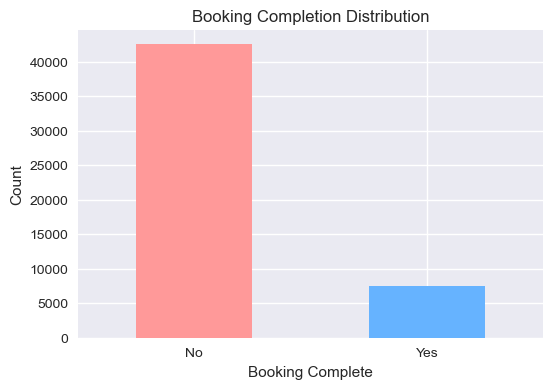

Booking completion rate: 14.96%


In [ ]:
## Target Variable Analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['booking_complete'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff'])
plt.title('Booking Completion Distribution')
plt.xlabel('Booking Complete')
plt.ylabel('Count')
plt.xticks([0,1], ['No', 'Yes'], rotation=0)
plt.show()

print(f"Booking completion rate: {df['booking_complete'].mean()*100:.2f}%")

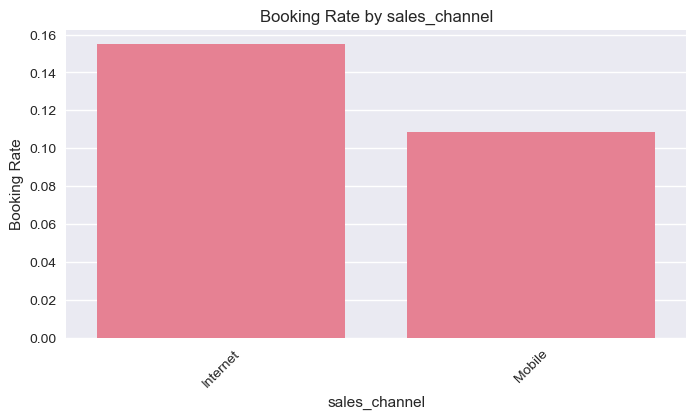

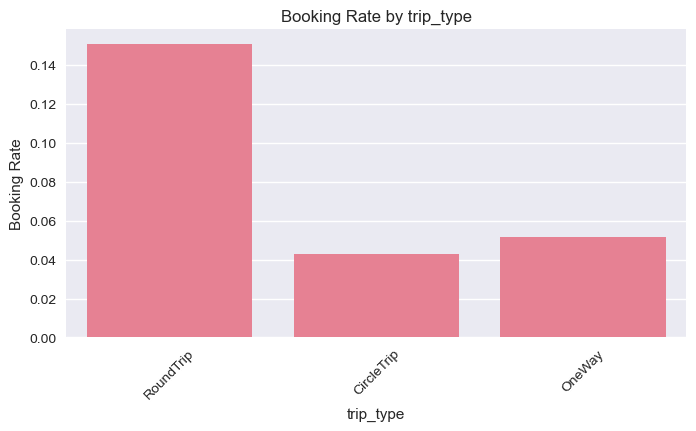

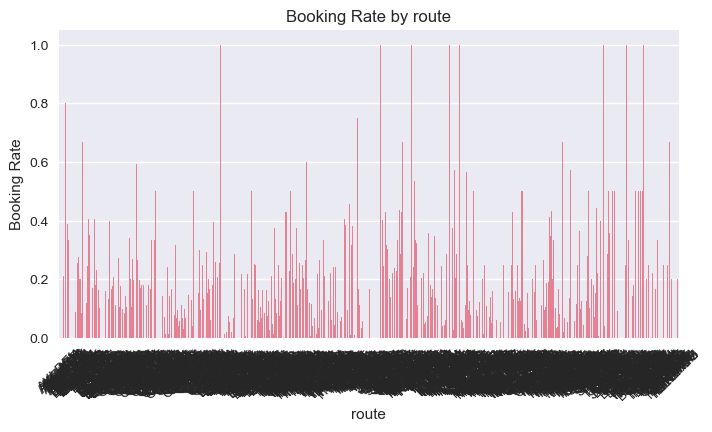

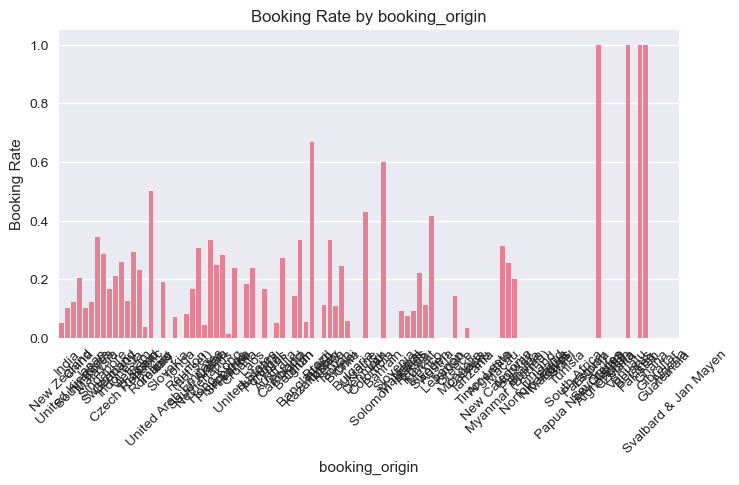

In [10]:
## Booking rate by categorical variables
import seaborn as sns

categorical_cols = ['sales_channel', 'trip_type', 'route', 'booking_origin']
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='booking_complete', data=df, ci=None)
    plt.title(f'Booking Rate by {col}')
    plt.ylabel('Booking Rate')
    plt.xticks(rotation=45)
    plt.show()

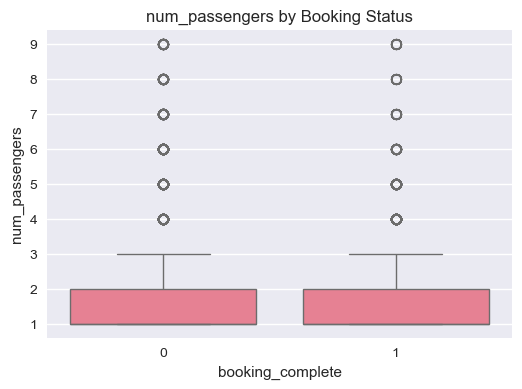

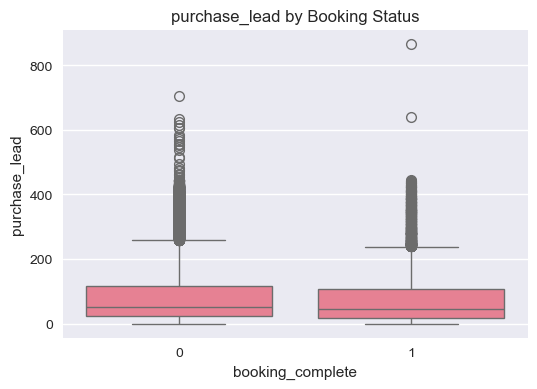

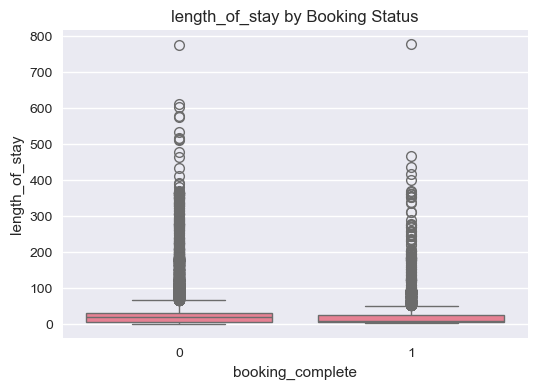

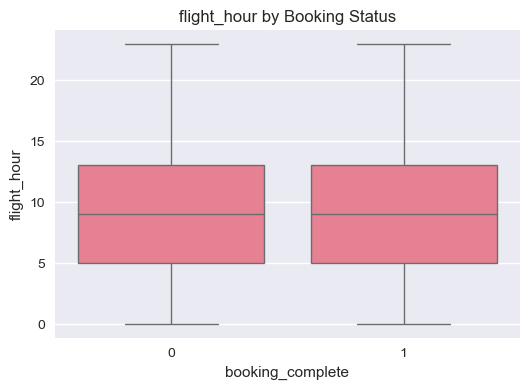

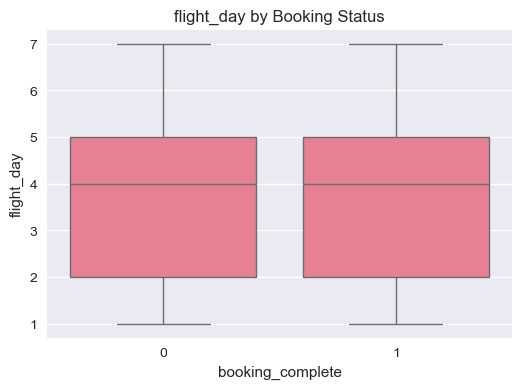

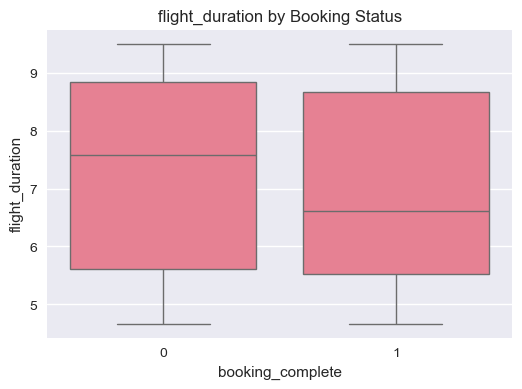

In [11]:
#Box plot for numerical columns
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'flight_duration']
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='booking_complete', y=col, data=df)
    plt.title(f'{col} by Booking Status')
    plt.show()

In [12]:
# feature engineering
df['is_weekend'] = df['flight_day'].isin([6, 7]).astype(int)
df['is_morning'] = df['flight_hour'].between(6, 11).astype(int)
df['is_evening'] = df['flight_hour'].between(18, 23).astype(int)
df['total_services'] = df['wants_extra_baggage'] + df['wants_preferred_seat'] + df['wants_in_flight_meals']
df['route_origin'] = df['route'].str[:3]
df['route_destination'] = df['route'].str[3:]
df['purchase_lead_category'] = pd.cut(df['purchase_lead'], bins=[0, 7, 30, 90, 1000], labels=['Last minute', 'Short term', 'Medium term', 'Long term'])

In [13]:
##Encode Categorical Variables
from sklearn.preprocessing import LabelEncoder

categorical_features = ['sales_channel', 'trip_type', 'route_origin', 'route_destination', 'booking_origin', 'purchase_lead_category']
for col in categorical_features:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col].astype(str))

In [14]:
## Prepare Data for Modeling
# Select features for modeling
feature_columns = [
    'num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day',
    'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
    'is_weekend', 'is_morning', 'is_evening', 'total_services'
] + [col + '_enc' for col in categorical_features]

X = df[feature_columns]
y = df['booking_complete']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
#Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [16]:
#Evaluate Model Performance
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation ROC-AUC scores: [0.76237443 0.76037083 0.7713411  0.74471107 0.75439794]
Mean CV ROC-AUC: 0.7586 (+/- 0.0177)


In [17]:
#Classification Report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8504
           1       0.58      0.11      0.18      1496

    accuracy                           0.86     10000
   macro avg       0.72      0.55      0.55     10000
weighted avg       0.82      0.86      0.81     10000



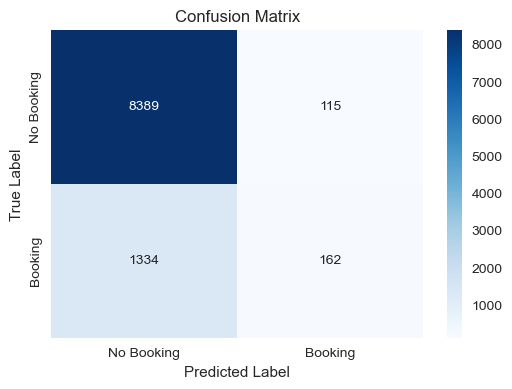

In [18]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Booking', 'Booking'], yticklabels=['No Booking', 'Booking'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

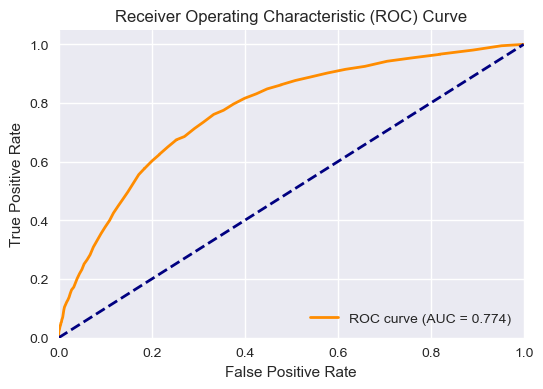

In [19]:
#ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Top 10 Most Important Features:
                       feature  importance
1                purchase_lead    0.161216
3                  flight_hour    0.116179
2               length_of_stay    0.115199
17          booking_origin_enc    0.097563
15            route_origin_enc    0.095328
4                   flight_day    0.076907
16       route_destination_enc    0.075855
8              flight_duration    0.056844
0               num_passengers    0.045767
18  purchase_lead_category_enc    0.037057


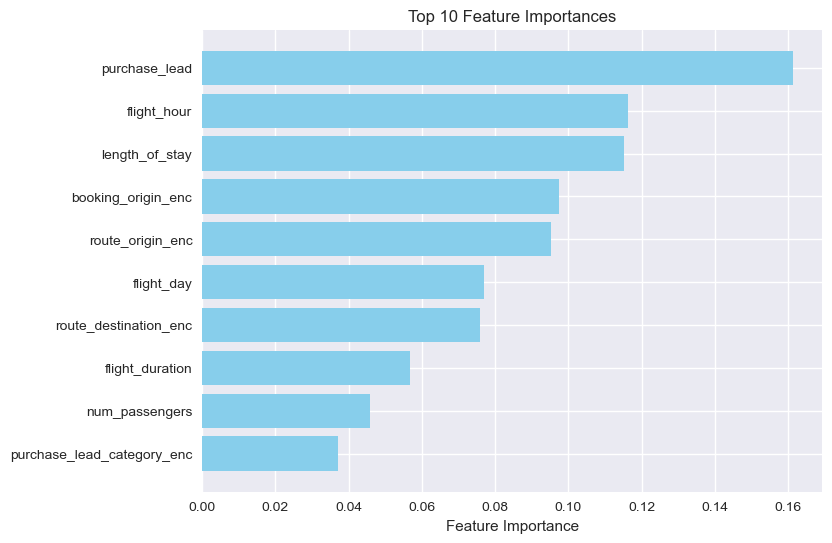

In [20]:
# Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(8,6))
plt.barh(feature_importance['feature'][:10][::-1], feature_importance['importance'][:10][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()